In [1]:
import math
import numpy as np
import pandas as pd
import pints
import matplotlib.pyplot as plt
import os
plt.rcParams.update({'font.size': 24})
from Newton_model_numba import wrappedNewton, newtonRaphsonFT

In [2]:
class ComplexRootMeanSquaredError_harmonics(pints.ProblemErrorMeasure):
    def __init__(self, problem, model, Hz_interval, times, adjustment = -1, fourthAdjustment = -4):
        super(ComplexRootMeanSquaredError_harmonics, self).__init__(problem)

        if not isinstance(problem, pints.SingleOutputProblem):
            raise ValueError(
                'This measure is only defined for single output problems.')
        
        self.FT_values = model.FT_and_reduce_to_harmonics_4_to_12(self._values)
        self.harmonic_spacing = model.harmonic_spacing(self._values, times, adjustment = adjustment)
        print('harmonic_spacing (480): ', self.harmonic_spacing)
        self.freq = model.frequencies_for_harmonics_4_to_12(times =times)
        x = np.where(self.freq < model.freq*4)
        self.mid_point_index = x[0][-1] + fourthAdjustment
        print('mid_point_index (89): ', self.mid_point_index)
        self.index_window = int(np.round(model.index_distance_covering(Hz_interval, times)))
        print('index_window (32): ', self.index_window)
        self.data_dims = self.FT_values.shape[0]

        # np.absolute takes the element wise absoulte value of real numbers, 
        # and the element-wise modules/eulcdiean norm/ absoulte value of comlex numbers
        # i.e for: z = a +bi
        # |z| = sqrt(a^2+b^2)

    def __call__(self, x):

        simulation = self._problem.evaluate(x)
        reduced_FT_sim = model.FT_and_reduce_to_harmonics_4_to_12(simulation)

        low = int(self.mid_point_index - self.index_window)
        mid = int(self.mid_point_index)
        high = int(self.mid_point_index+ self.index_window + 1)

        total_complex_diff = 0.0
        harmonic = 4   
        while high <= self.data_dims:
            sim_harmonic = reduced_FT_sim[low:high]
            exp_harmonic = self.FT_values[low:high]

            # plt.figure(figsize=(18,10))
            # plt.title("simulation FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq[low:high], np.log10(sim_harmonic),'r', label='simulated_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(reduced_FT_sim[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            # plt.figure(figsize=(18,10))
            # plt.title("experimental FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq[low:high], np.log10(exp_harmonic),'b', label='experimental_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(self.FT_values[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            # plt.figure(figsize=(18,10))
            # plt.title("experimental FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq, np.log10(self.FT_values),'k', label='experimental harm 4 -12')
            # plt.plot(self.freq[low:high], np.log10(exp_harmonic),'b', label='experimental_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(self.FT_values[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            # plt.figure(figsize=(18,10))
            # plt.title("simulated on experimental FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq, np.log10(self.FT_values),'k', label='experimental harm 4 -12')
            # plt.plot(self.freq[low:high], np.log10(sim_harmonic),'r', label='simulated_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(reduced_FT_sim[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            # plt.figure(figsize=(18,10))
            # plt.title("simulated on experimental FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq[low:high], np.log10(exp_harmonic),'b', label='experimental_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(self.FT_values[mid]),'kX', label='harmonic_center')
            # plt.plot(self.freq[low:high], np.log10(sim_harmonic),'r', label='simulated_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(reduced_FT_sim[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            kaiser_window = np.kaiser(exp_harmonic.shape[0], 0)

            complex_diff = sim_harmonic - exp_harmonic

            windowed = np.multiply(kaiser_window,complex_diff)

            total_complex_diff = total_complex_diff + windowed

            # increasing indexing
            high = high + self.harmonic_spacing
            mid = mid + self.harmonic_spacing
            low = low + self.harmonic_spacing

            harmonic = harmonic + 1

        # complex_diff = reduced_FT_sim - self.FT_values

        # magnatuide = np.absolute(complex_diff)

        magnatuide = np.absolute(total_complex_diff)

        squares = np.square(magnatuide)

        sumed = np.sum(squares)

        return np.sqrt(sumed)

In [3]:
# # specifing files and model 
# # specifing data location and folder for outputs

# Phfolder = ['ph4 2m nacl 25oC','ph5 2m nacl 25oC','ph6 2m nacl 25oC','ph7 2m nacl 25oC','ph8 2m nacl 25oC','ph9 2m nacl 25oC']

# data_file_names = ['9_1b_cv_current_reduced_0', '9 150_1_cv_current_reduced_0',
#                     '9 150_1_cv_current_reduced_0', '9 150_1_cv_current_reduced_0',
#                     '9 150_1_cv_current_reduced_0', '9 150_1_cv_current_reduced_0']

# experiment_folder = ['9_1b', '9 150_1',
#                      '9 150_1', '9 150_1',
#                      '9 150_1', '9 150_1']


# startPotential_list = [-50.0E-3, -100.0E-3, -150.0E-3, -200.0E-3, -250.0E-3, -300.0E-3]
# revPotential_list = [-650.0E-3, -700.0E-3, -750.0E-3, -800.0E-3, -850.0E-3, -900.0E-3]
# uncomp_resis_list = [3.25459258134767921e+01, 5.37315648829909520e+01, 7.08611444464832800e+01, 9.96182105930900406e+01, 1.21158504446797167e+02, 8.49461271867468355e+01]

# cap_params_list = [[1.86297231895378234e-04,  1.39822668111257240e-04,  3.70334763842398995e-04,  1.95151458630165057e-04,
#                     1.89160175800536629e-04,  1.72641582414570635e-04,  4.39360685286188006e-04,  2.43245044482993467e-04,
#                     -6.47033620007000394e+01],

#                     [1.94632384807037420e-04,  1.09253279202811606e-04,  2.88119296913558502e-04,  1.26365659832472976e-04,
#                     2.02905524533143831e-04,  1.80802994708567557e-04,  4.31389682179686342e-04,  2.20819252636918900e-04,
#                     -6.47033294616361019e+01],

#                     [2.04723750338681946e-04,  2.31336124514676302e-05,  6.72508062131533472e-05, -3.52789052587041763e-05,
#                     2.19537063820266680e-04,  1.36486944707261103e-04,  2.84492337211128500e-04,  9.96760436029462717e-05,
#                     -6.47033565846734575e+01],

#                     [2.31095670596632297e-04, -3.33935918269465505e-05,  2.61213767197990623e-05, -4.37105855050501238e-05,
#                     2.48585910357163357e-04,  8.43384306423355847e-05,  2.31490537079119671e-04,  7.27245330412529863e-05,
#                     -6.47034052381796130e+01],

#                     [2.10391107458934992e-04, -1.67952604491567012e-04, -2.27521114816858663e-04, -1.82193875674134206e-04,
#                     2.37152182054913105e-04, -1.71348627672825594e-05,  1.08690359778462926e-05, -5.80862929614741437e-05,
#                     -6.47034055661957552e+01],
                    
#                     [1.66897412567862006e-04, -3.31979915125576596e-04, -5.19143040976281084e-04, -3.20477836314988726e-04,
#                     2.13029444583132078e-04, -9.50966568724915390e-05, -1.66949344271613391e-04, -1.49813542866588539e-04,
#                     -6.47034179321291987e+01]
#                     ]

# # know paramteres for 9 150_1_cv_current_reduced_2
# freq = 8.977950e+00
# rateOfPotentialChange = -22.35174e-3

# deltaepislon = 150.0E-3
# electrode_area = 0.03
# electode_coverage = 6.5e-12


# Hz_interval_fitting_interval = 0.8

experimental data:  Data/processed/220415/ph6 2m nacl 25oC/ac/9 150_1/experimental/9 150_1_cv_current_reduced_0.txt
x[0][-1]:  482
y[0][0]:  483
z[0]:  []


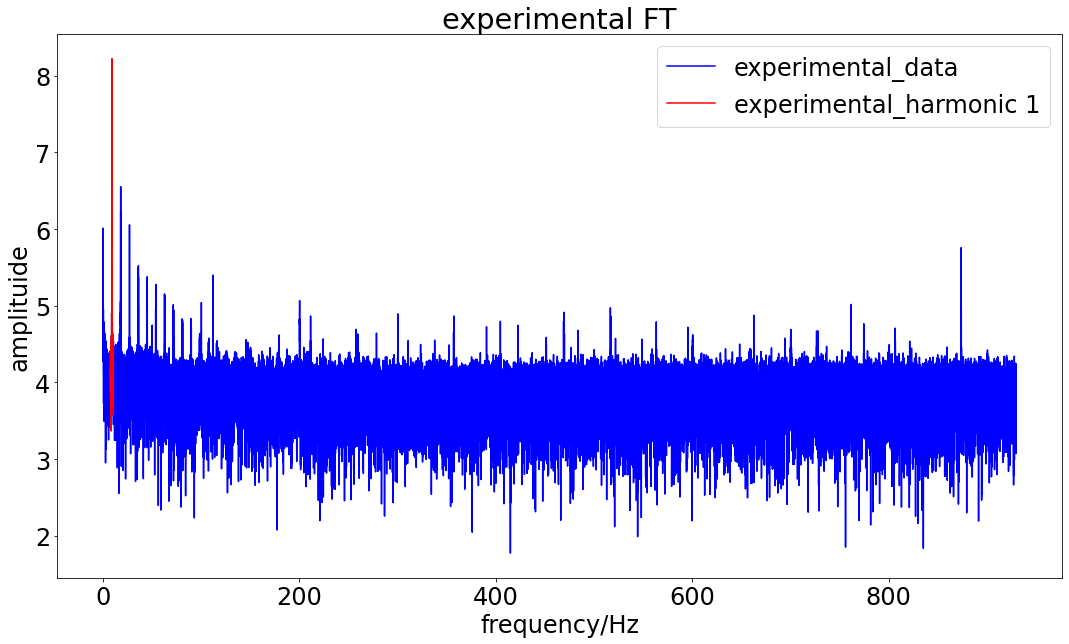

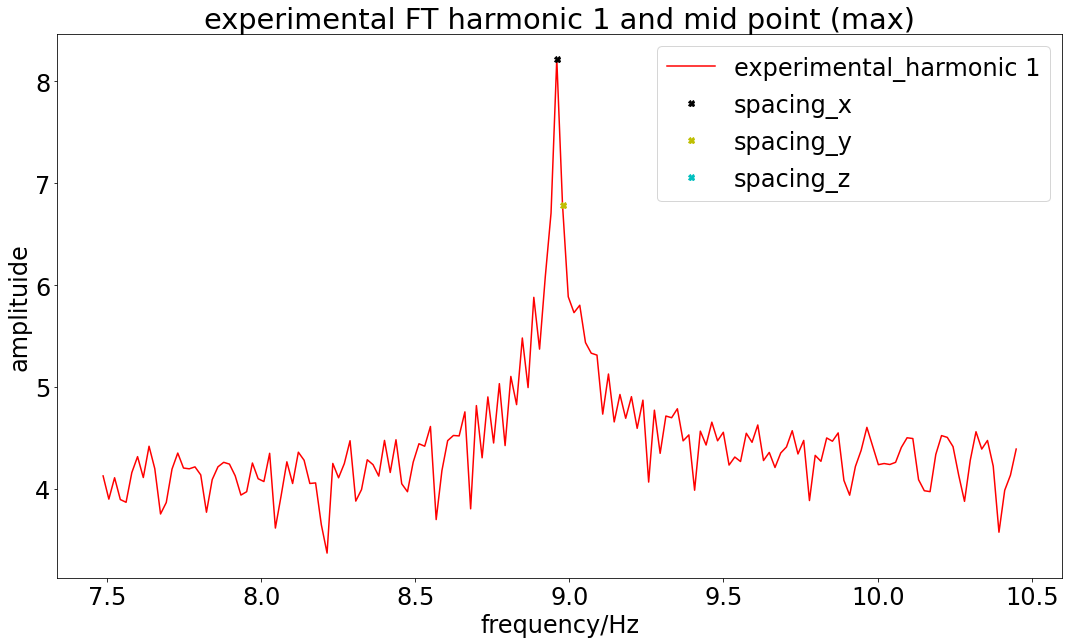

harmonic_spacing (480):  481
mid_point_index (89):  177
index_window (32):  24
dims:  (6,)
dims[0]:  6


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.     0.    -0.63  -0.63  -0.314  0.   ]
upper_bounds:  [ 1.00e+04  1.00e+04 -2.70e-01 -2.70e-01  3.14e-01  1.00e+01]
random starting points:  [3900.0, 3900.0, -0.46635681158628695, -0.44278425859499376, 0.02279690724275868, 0.48098743439266595]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      306084.9   0:13.5
1     18     304292.6   0:14.3
2     27     303304     0:15.1
3     36     303304     0:15.8
20    189    303191.9   0:28.6
40    369    303094     0:43.8
60    549    302257.1   0:58.8
80    729    301739.8   1:13.8
100   909    301338     1:29.1
120   1089   301175.6   1:44.1
140   1269   301109.5   1:59.0
160   1449   3

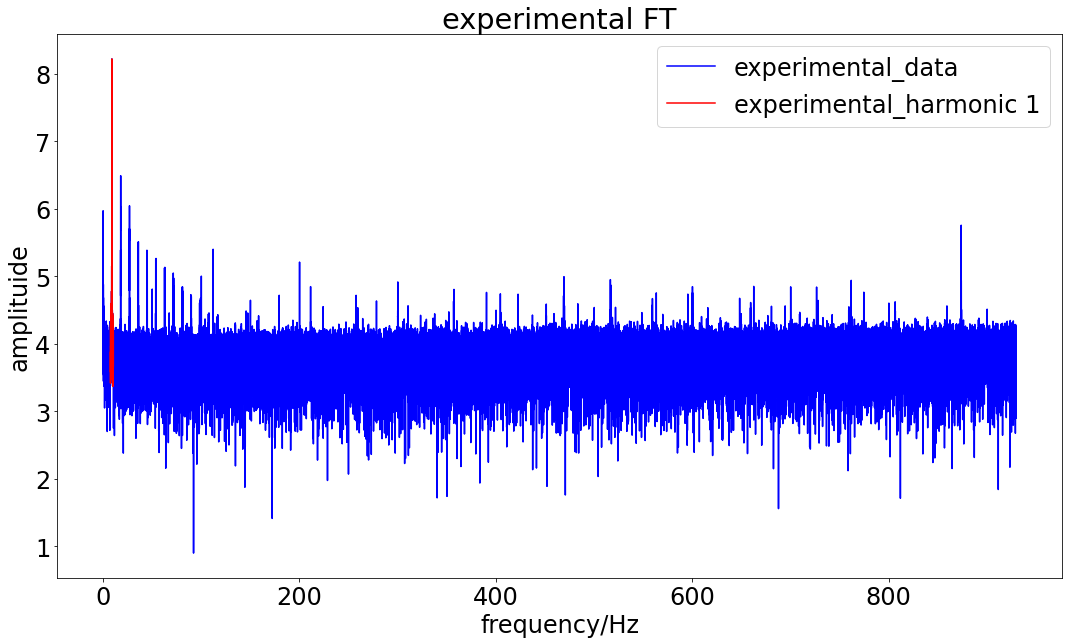

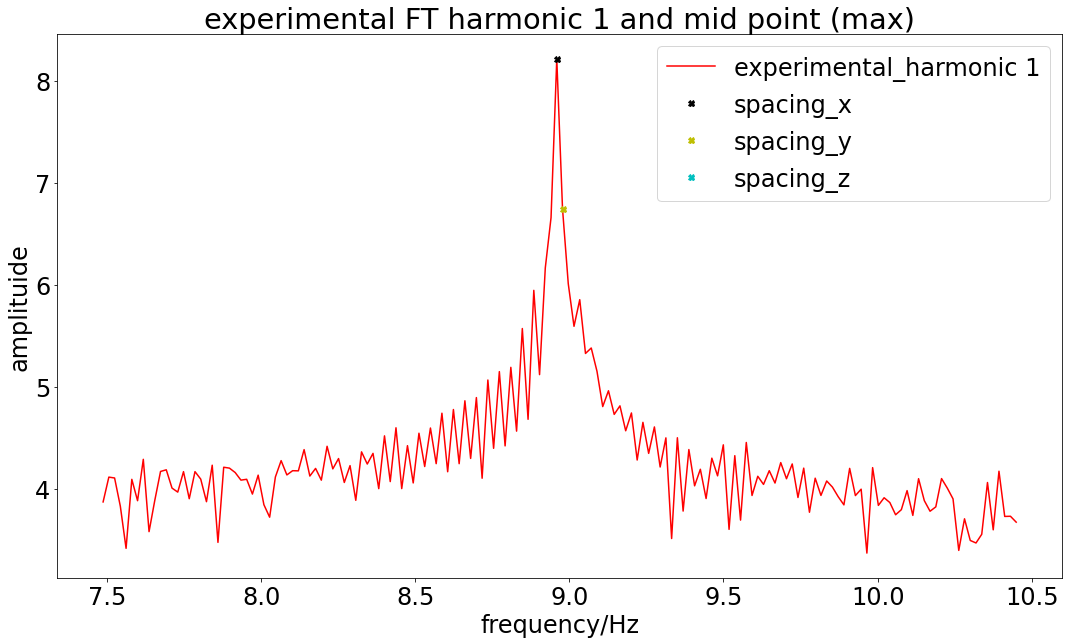

harmonic_spacing (480):  481
mid_point_index (89):  177
index_window (32):  24
dims:  (6,)
dims[0]:  6


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.     0.    -0.63  -0.63  -0.314  0.   ]
upper_bounds:  [ 1.00e+04  1.00e+04 -2.70e-01 -2.70e-01  3.14e-01  1.00e+01]
random starting points:  [3900.0, 3900.0, -0.46635681158628695, -0.44278425859499376, 0.02279690724275868, 0.48098743439266595]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      272127.5   0:00.8
1     18     250379.4   0:01.5
2     27     249719.5   0:02.3
3     36     247263.2   0:03.0
20    189    242961.7   0:15.8
40    369    242844.5   0:30.7
60    549    242792.9   0:45.7
80    729    242379.2   1:00.9
100   909    241112.3   1:16.0
120   1089   240569.4   1:31.1
140   1269   240474.6   1:46.0
160   1449   2

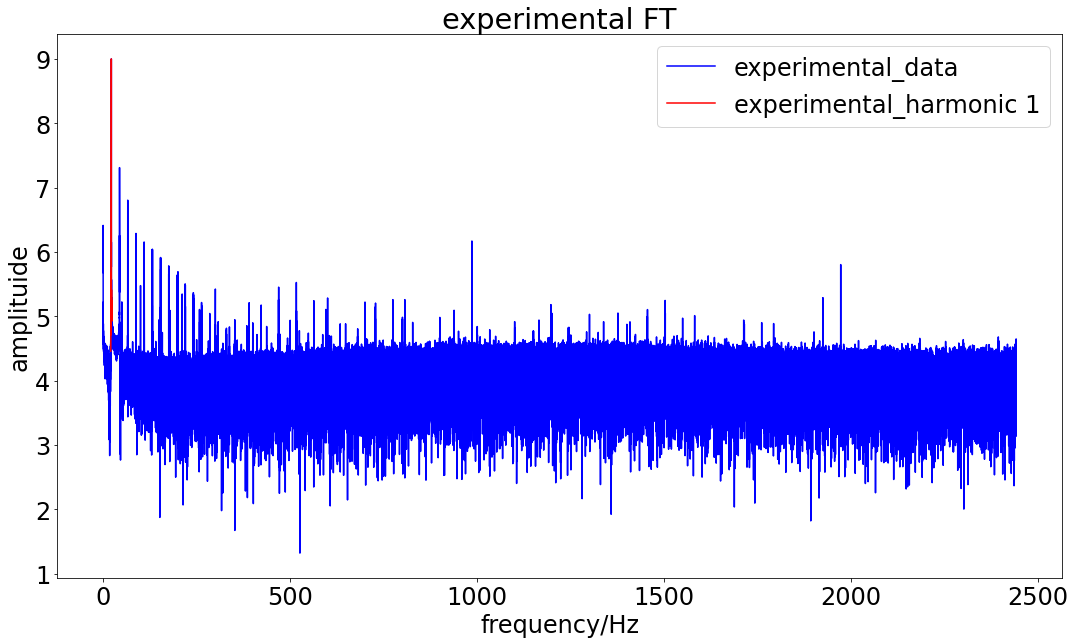

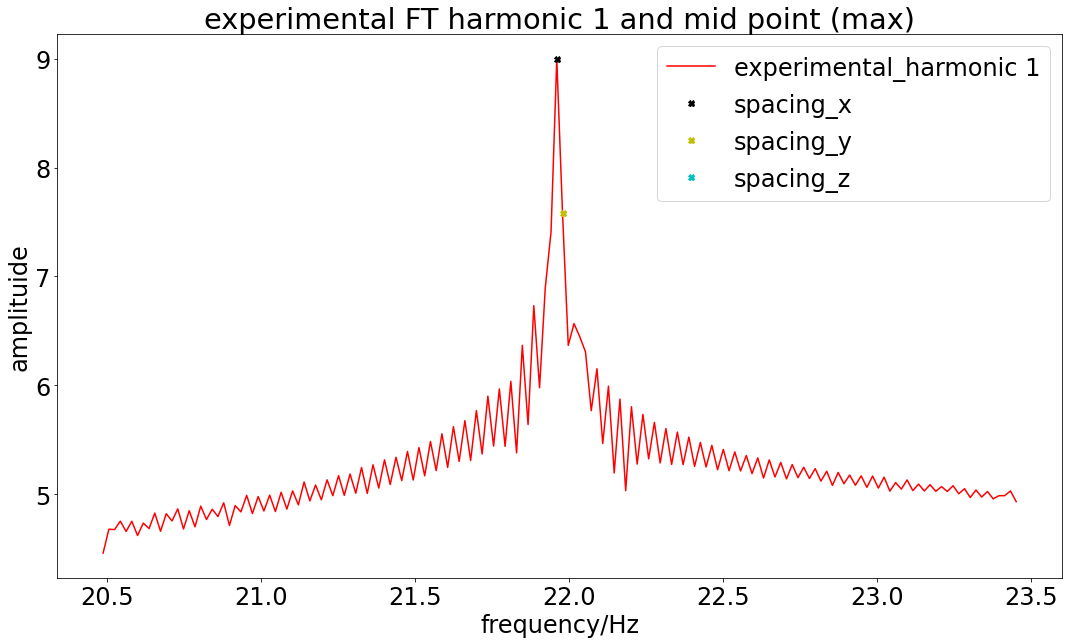

harmonic_spacing (480):  1178
mid_point_index (89):  784
index_window (32):  59
dims:  (6,)
dims[0]:  6


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.     0.    -0.63  -0.63  -0.314  0.   ]
upper_bounds:  [ 1.00e+04  1.00e+04 -2.70e-01 -2.70e-01  3.14e-01  1.00e+01]
random starting points:  [3900.0, 3900.0, -0.46635681158628695, -0.44278425859499376, 0.02279690724275868, 0.48098743439266595]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      1536348    0:02.4
1     18     1499830    0:04.7
2     27     1499830    0:06.7
3     36     1499830    0:08.8
20    189    1484617    0:44.1
40    369    1472289    1:25.9
60    549    1465361    2:08.1
80    729    1442367    2:49.8
100   909    1433487    3:31.2
120   1089   1429618    4:13.2
140   1269   1428499    4:54.3
160   1449   

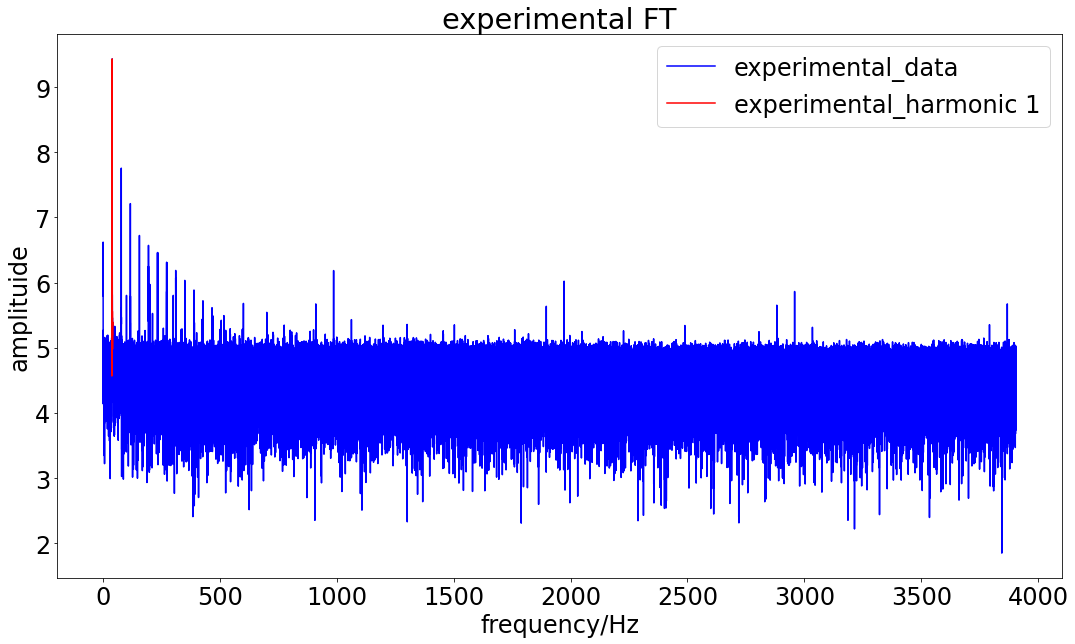

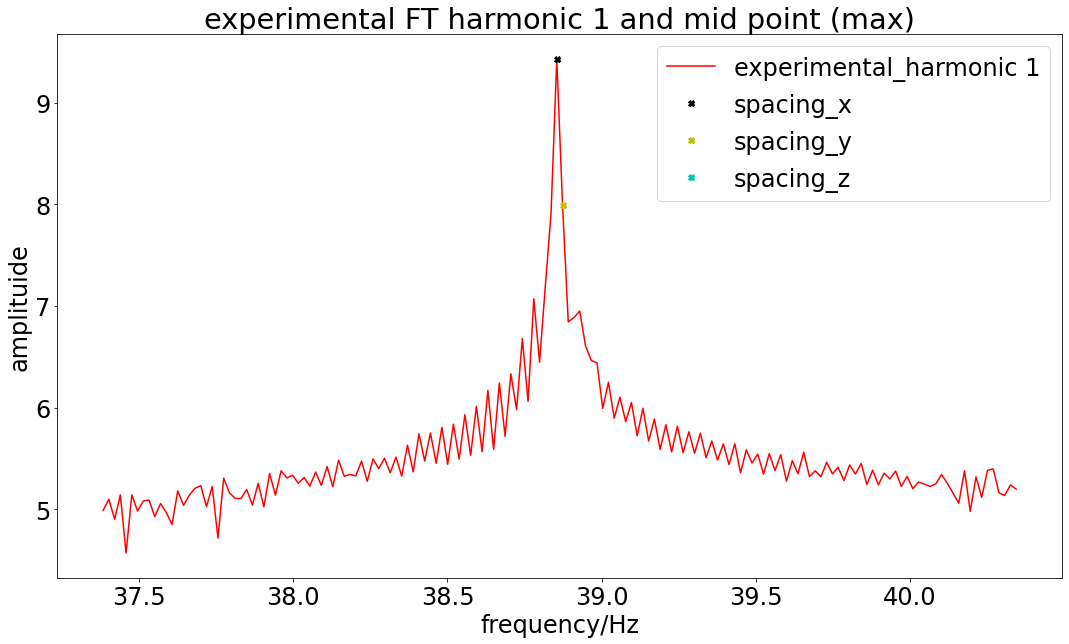

harmonic_spacing (480):  2086
mid_point_index (89):  2053
index_window (32):  52
dims:  (6,)
dims[0]:  6


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.     0.    -0.63  -0.63  -0.314  0.   ]
upper_bounds:  [ 1.00e+04  1.00e+04 -2.70e-01 -2.70e-01  3.14e-01  1.00e+01]
random starting points:  [3900.0, 3900.0, -0.46635681158628695, -0.44278425859499376, 0.02279690724275868, 0.48098743439266595]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      4285825    0:03.5
1     18     4079391    0:06.9
2     27     4079391    0:10.4
3     36     4037138    0:13.6
20    189    3905035    1:12.7
40    369    3863159    2:22.2
60    549    3802588    3:31.8
80    729    3740695    4:41.5
100   909    3684694    5:51.3
120   1089   3656214    7:01.3
140   1269   3641958    8:11.0
160   1449  

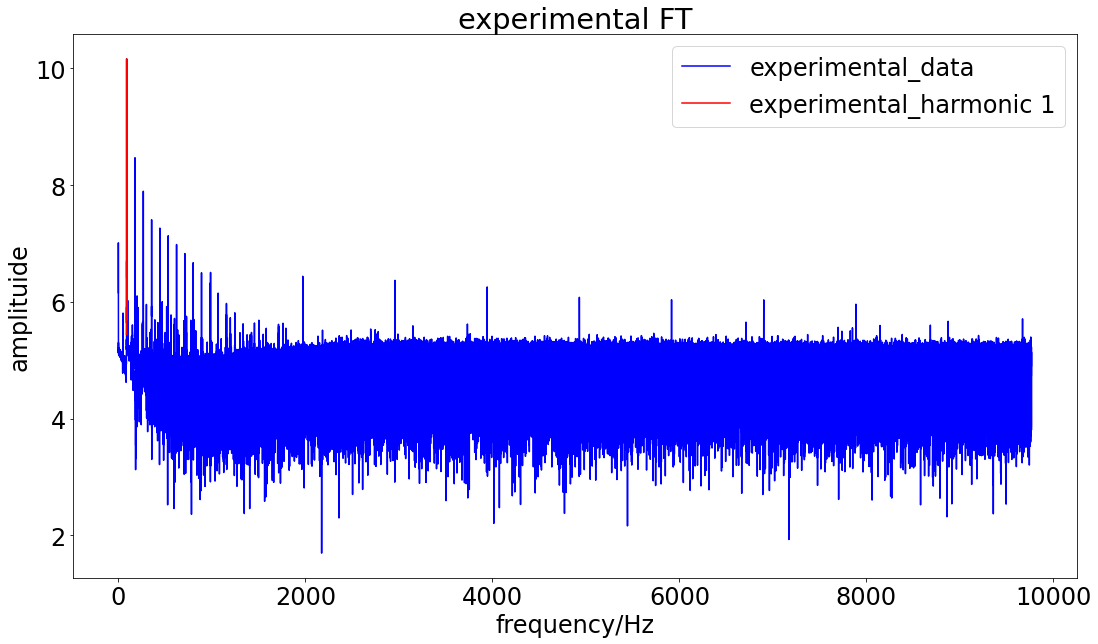

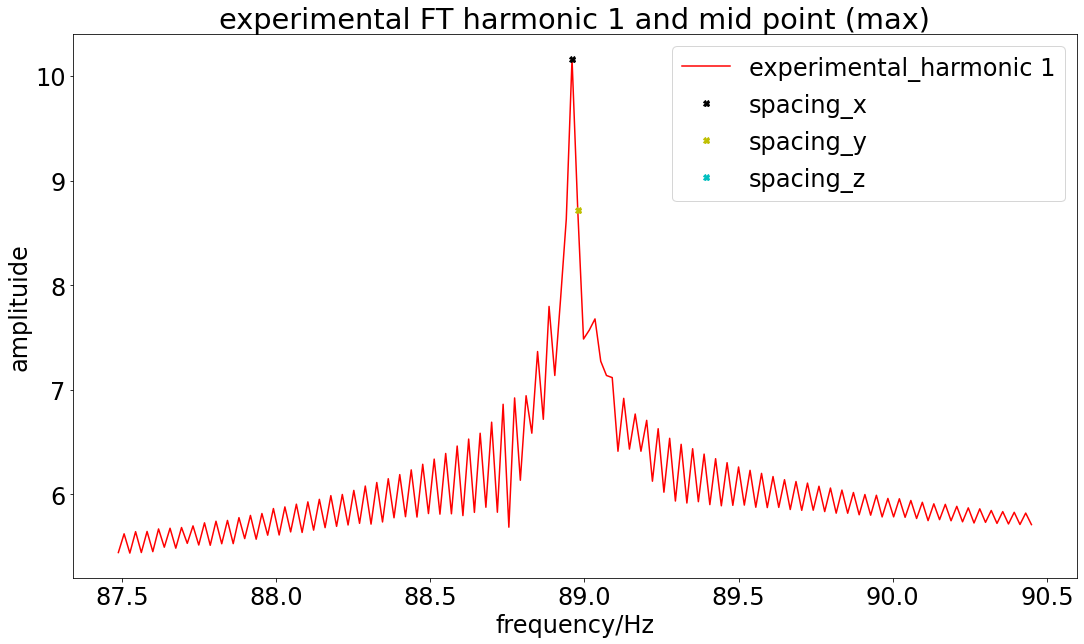

harmonic_spacing (480):  4775
mid_point_index (89):  3375
index_window (32):  119
dims:  (6,)
dims[0]:  6


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.     0.    -0.63  -0.63  -0.314  0.   ]
upper_bounds:  [ 1.00e+04  1.00e+04 -2.70e-01 -2.70e-01  3.14e-01  1.00e+01]
random starting points:  [3900.0, 3900.0, -0.46635681158628695, -0.44278425859499376, 0.02279690724275868, 0.48098743439266595]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      4.55e+07   0:09.0
1     18     4.31e+07   0:18.6
2     27     4.08e+07   0:27.0
3     36     3.55e+07   0:36.2
20    189    2.15e+07   3:08.8
40    369    1.77e+07   6:06.7
60    549    1.66e+07   9:05.3
80    729    1.63e+07  12:02.2
100   909    1.63e+07  14:59.5
120   1089   1.62e+07  17:58.4
140   1269   1.61e+07  20:54.8
160   1449 

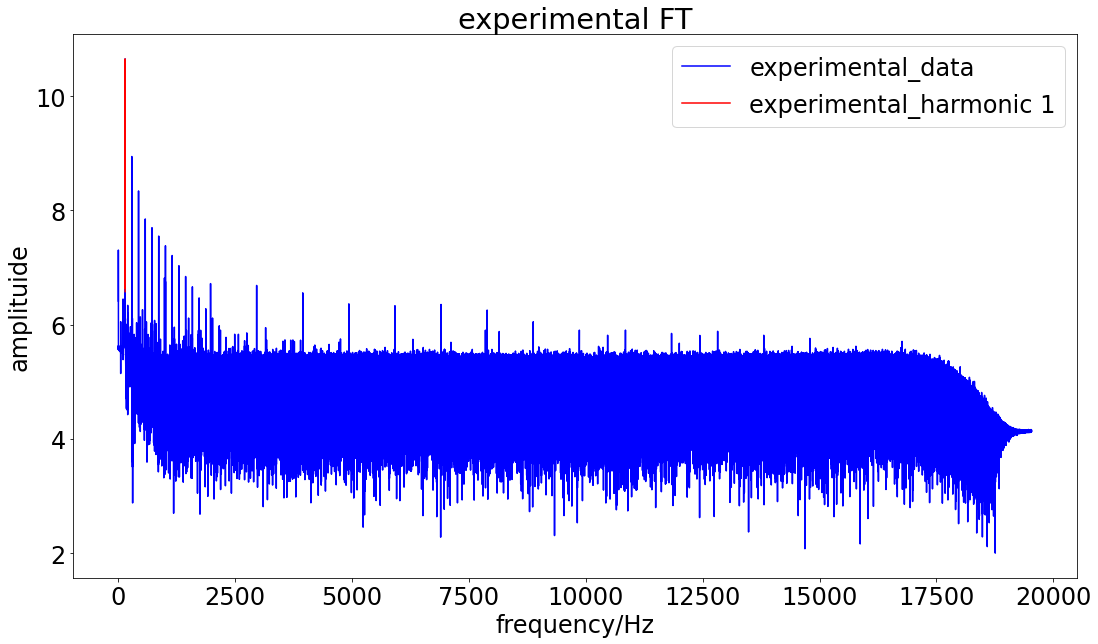

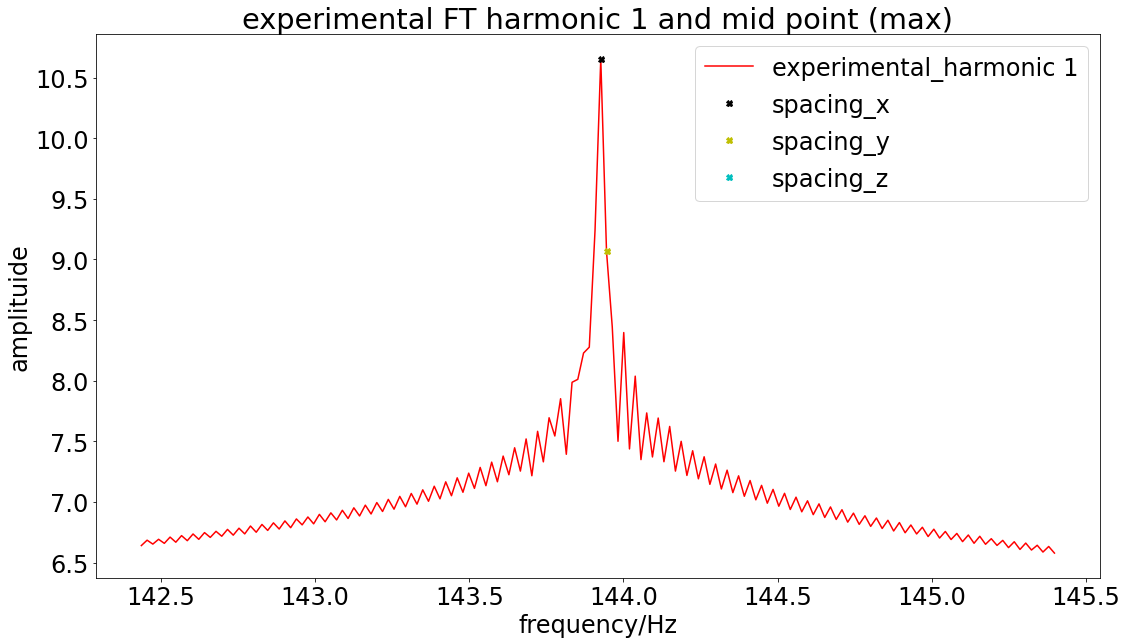

harmonic_spacing (480):  7727
mid_point_index (89):  4694
index_window (32):  193
dims:  (6,)
dims[0]:  6


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.     0.    -0.63  -0.63  -0.314  0.   ]
upper_bounds:  [ 1.00e+04  1.00e+04 -2.70e-01 -2.70e-01  3.14e-01  1.00e+01]
random starting points:  [3900.0, 3900.0, -0.46635681158628695, -0.44278425859499376, 0.02279690724275868, 0.48098743439266595]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      2.24e+08   0:14.4
1     18     2.21e+08   0:28.9
2     27     1.89e+08   0:43.1
3     36     1.69e+08   0:58.1
20    189    8.03e+07   5:01.7
40    369    5.96e+07   9:47.9
60    549    5.21e+07  14:33.3
80    729    4.97e+07  19:20.3
100   909    4.87e+07  24:05.9
120   1089   4.83e+07  28:51.9
140   1269   4.82e+07  33:33.4
160   1449 

In [4]:
 %%time

for index in range(6):
    # specifing files and model 
    # specifing data location and folder for outputs

    Phfolder = ['ph6 2m nacl 25oC', 'ph6 2m nacl 25oC', 'ph6 2m nacl 25oC','ph6 2m nacl 25oC','ph6 2m nacl 25oC', 'ph6 2m nacl 25oC']

    data_file_names = ['9 150_1_cv_current_reduced_0', '9 150_2_cv_current_reduced_0',
                       '22 150_1_cv_current_reduced_221', '39 150_1_cv_current_reduced_0',
                       '89 150_1_cv_current_reduced_219', '144 150_1_cv_current_end_of_2']

    experiment_folder = ['9 150_1', '9 150_2', '22 150_1', '39 150_1', '89 150_1', '144 150_1']


    startPotential_list = [-150.0E-3, -150.0E-3, -150.0E-3, -150.0E-3, -150.0E-3, -150.0E-3]
    revPotential_list = [-750.0E-3, -750.0E-3, -750.0E-3, -750.0E-3, -750.0E-3, -750.0E-3]
    uncomp_resis_list = [7.08611591057770340e+01, 4.91093481559957326e+01, 2.01411535318853758e+01, 2.23182264695035428e+01, 1.96482517263278993e+01, 2.09519630207853176e+01]

    cap_params_list = [[2.04723758044318639e-04,  2.31336630663295413e-05,  6.72509298629887266e-05, -3.52788102432985851e-05,
                        2.19537056057108508e-04,  1.36486908914754557e-04,  2.84492284788390691e-04,  9.96760202484289499e-05,
                        5.62930284827410787e+01],
                        
                        [2.16710586810792046e-04,  1.18587299092851907e-04,  2.52608752696916166e-04,  7.92142129549119282e-05,
                        2.19857071201662492e-04,  1.42935895485438690e-04,  2.93898841574842268e-04,  1.06914218445532550e-04,
                        5.62930603148047979e+01],
                        
                        [1.95036308433046431e-04,  4.16836176649199031e-05,  1.08476307143738973e-04,  4.57902518473211895e-06,
                        2.04911057528037486e-04,  1.24891867796406153e-04,  2.68891849089009441e-04,  1.03444269036792255e-04,
                        1.37982415501857133e+02],

                        [1.82244462745964972e-04,  3.22915907532139723e-05,  1.15220578724525846e-04,  2.39170694579168841e-05,
                        1.93525991879424895e-04,  1.08993626921988218e-04,  2.47156234229590696e-04,  9.92317543972581761e-05,
                        2.44131723579202685e+02],

                        [1.72675739723287516e-04,  3.18377516059498416e-05,  1.10201537678792857e-04,  2.68574147372824170e-05,
                        1.81036871311967813e-04,  9.75661138288184352e-05,  2.29747226576177506e-04,  9.70968147269177326e-05,
                        5.58951728494219310e+02],

                        [1.65820958397597593e-04,  3.24953836739808304e-05,  1.14676177668029998e-04,  3.53523018547740285e-05,
                        1.72840122333479588e-04,  8.92861782445008093e-05,  2.17432965000437890e-04,  9.52028067529504286e-05,
                        9.04317435750307368e+02],

                        ]
    
    initalDiscard_list = [0.035, 0.035, 0.030, 0.030, 0.030, 0.025]
    endDiscard_lst = [0.880, 0.880, 0.885, 0.875, 0.885, 0.905]
    # know paramteres for 9 150_1_cv_current_reduced_2
    freq_list= np.asarray([8.977950e+00, 8.977950e+00, 2.197921e+01, 3.887340e+01, 8.897856e+01, 1.439452e+02])
    rateOfPotentialChange = -22.35174e-3

    deltaepislon = 150.0E-3
    electrode_area = 0.03
    electode_coverage = 6.5e-12


    Hz_interval_fitting_interval = freq_list*0.025
    Hz_interval_fitting_interval[0] = freq_list[0]*0.05
    Hz_interval_fitting_interval[1] = freq_list[1]*0.05
    Hz_interval_fitting_interval[2] = freq_list[2]*0.05

    adjustment = [-1, -1, -1, -1, -1, 0]
    fourthAdjustment = [-4, -4, -4, -4, -4, -3]

    data_name = data_file_names[index]
    file_name = data_name + '.txt'
    folder = os.path.join('Data', 'processed')
    folder = os.path.join(folder, '220415')
    folder = os.path.join(folder, Phfolder[index])
    folder = os.path.join(folder, 'ac')
    folder = os.path.join(folder, experiment_folder[index])
    data_file = os.path.join(folder, 'experimental')
    data_file = os.path.join(data_file, file_name)

    # creating file for output
    fitting_technique = 'harmonic '
    output_file_name = fitting_technique + 'fitting_for_faradaic_data'
    output_file_name = output_file_name + '.txt'
    folder = os.path.join(folder, 'faradaic_fitting')
    folder = os.path.join(folder, 'harmonics4-12')
    f= open(os.path.join( folder, output_file_name),"w")

    # opening data
    experimental_data = pd.read_csv(data_file, sep='\t')

    exp_times = np.asarray(experimental_data.time)
    exp_current = np.asarray(experimental_data.current)

    # know paramteres that are data specific
    inital_current = exp_current[index]
    startPotential= startPotential_list[index]
    revPotential = revPotential_list[index]
    uncomp_resis = uncomp_resis_list[index]

    # delacring capactiance parameters
    # (gamma0, gamma1, gamma2, gamma3, omega)
    cap_params = cap_params_list[index][:]

    measurements = exp_current.shape[0]
    # print('measurements: ', measurements)
    # if measurements%2 !=0:
    #     print('*'*30+'\nerror must have evennumber of measurments\n'+'*'*40)

    # declaring model to obtain non dimensinalise constant
    trial = newtonRaphsonFT(timeStepSize=exp_times[1], inital_current=inital_current, freq=freq_list[index], startPotential= startPotential, revPotential = revPotential,
                            rateOfPotentialChange = rateOfPotentialChange, numberOfMeasurements = measurements, deltaepislon=deltaepislon,
                            uncomp_resis=uncomp_resis, electrode_area=electrode_area, electode_coverage=electode_coverage)

    # non-diming experimental data
    exp_current_dimless = exp_current/trial.I0

    # model for optimsation
    model = wrappedNewton(times = exp_times, inital_current=inital_current, freq=freq_list[index], startPotential= startPotential,
                            revPotential = revPotential, rateOfPotentialChange = rateOfPotentialChange, deltaepislon=deltaepislon,
                            uncomp_resis=uncomp_resis, electrode_area=electrode_area, electode_coverage=electode_coverage,
                            initaldiscard = initalDiscard_list[index], enddiscard = endDiscard_lst[index], cap_params=cap_params)

    real_parameters = model.suggested_parameter()
    parameter_order = ['kappa0_1', 'kappa0_2', 'epsilon0_1', 'epsilon0_2', 'mew', 'zeta']
    real_parameters = np.asarray(real_parameters)
    real_parameters = np.asarray([4.00000000000000000e+03,  3.99999999972441947e+03, -5.03044038352866596e-01, -1.69999999999999984e-01,  2.18249911855460221e-01,  4.90950349026095523e-01])
    f.write("experimental data: " + data_file + "\r\n")
    print('experimental data: ',data_file)

    # checking loaction of harmonics 1-4
    half_of_measuremnts = int(measurements/2)

    # full FT and frequencies
    full_sim = np.fft.fft(exp_current_dimless)
    half_full_sim = full_sim[:half_of_measuremnts]

    freq_org = np.fft.fftfreq(exp_times.shape[-1], d= exp_times[1])
    freq_org=freq_org[:half_of_measuremnts]

    # regional FT and Frequency

    freq = model.frequencies_for_harmonics_4_to_12(exp_times)

    harmonics1To4 = model.FT_and_reduce_to_harmonics_4_to_12(exp_current_dimless)

    xaxislabel = "frequency/Hz" # "potential/V"
    plt.figure(figsize=(18,10))
    plt.title("experimental FT")
    plt.ylabel("amplituide")
    plt.xlabel(xaxislabel)
    plt.plot(freq_org, np.log10(half_full_sim),'b', label='experimental_data')
    plt.plot(freq, np.log10(harmonics1To4),'r', label='harmonics 4 to 12')
    plt.legend(loc='best')
    plt.savefig(os.path.join( folder, 'experiment FT data and range 4-12.pdf'))
    plt.close()

    xaxislabel = "frequency/Hz" # "potential/V"
    plt.figure(figsize=(18,10))
    plt.title("experimental harmonics 1 -4 ")
    plt.ylabel("amplituide")
    plt.xlabel(xaxislabel)
    plt.plot(freq, np.log10(harmonics1To4),'r', label='harmonics 4 to 12')
    plt.legend(loc='best')
    plt.savefig(os.path.join( folder, 'experiment FT harmonics 4-12.pdf'))
    plt.close()

    # declaring problem

    problem = pints.SingleOutputProblem(model, exp_times, exp_current_dimless)

    score = ComplexRootMeanSquaredError_harmonics(problem, model, Hz_interval=Hz_interval_fitting_interval[index], times=exp_times, adjustment = adjustment[index], fourthAdjustment = fourthAdjustment[index])

    e_min = model.startPotential + 0.2*(model.revPotential - model.startPotential)
    e_max = model.startPotential + 0.8*(model.revPotential - model.startPotential)

    lower_bounds = np.asarray([0.0, 0.0, e_max, e_max, -0.314, 0.0])#, 0.1])
    upper_bounds = np.asarray([10000.0, 10000.0, e_min, e_min, 0.314, 10])#, 4.5])

    boundaries = pints.RectangularBoundaries(lower_bounds, upper_bounds)

    # optimisimg
    total_runs = 5
    dims = real_parameters.shape
    print('dims: ', dims)
    print('dims[0]: ', dims[0])
    params_matrix = np.zeros((total_runs, dims[0]))
    for run in range(total_runs):
            
        if run > 0:
            f = open(os.path.join( folder, output_file_name),"a")

        f.write("\r\n\r\n" + 40*"*" + " Run: %d " % run + 40*"*" + "\r\n\r\n")
        print('\n\n' + 40*"*" + ' Run: ', run, ' ' + 40*"*" + '\n\n')
        accuracy = (2 + run)
        # f.write("Threshold for stopping: %e\r\n\r\n" % pow(10,-accuracy))
        # print('Threshold for stopping: ', pow(10,-accuracy))

        ranges = upper_bounds - lower_bounds 

        starting_points = np.copy(lower_bounds)
        for i in range(len(ranges)):
            starting_points[i] += ranges[i] * np.random.uniform(low = 0.001, high = 0.999)
        
        print('lower_bounds: ', lower_bounds)
        print('upper_bounds: ', upper_bounds)

        if run == 0:
            starting_points = [3.90e+03,  3.90e+03,
                              -4.66356811586286946e-01, -4.42784258594993763e-01,
                               2.27969072427586794e-02,  4.80987434392665947e-01]
        if run == 1:
            starting_points = [3.90e+03,  3.90e+03,
                               -4.86875179217235665e-01, -4.31265972729869274e-01,
                               1.96457222187349900e-01,  4.21913770749389849e-01]
        print('random starting points: ', starting_points)

        f.write("lower_bounds: ")
        for i in lower_bounds:
            f.write("%e, " % i)
        f.write("\r\nupper_bounds: ")
        for i in upper_bounds:
            f.write("%e, " % i)
        f.write("\r\nRandom starting_points: ")
        for i in starting_points:
            f.write("%e, " % i)
        f.write("\r\n")

        # transformation
        transform = pints.RectangularBoundariesTransformation(boundaries)

        # optimising boundaries=boundaries,
        opt = pints.OptimisationController(
            score,
            x0=starting_points,
            method=pints.CMAES,
            transform = transform)

            
        #opt.set_max_unchanged_iterations(iterations=50, threshold=pow(10,-accuracy))
        #opt.set_max_unchanged_iterations(iterations=100)
        opt.set_parallel(parallel=True)
        # opt.set_max_iterations(iterations=1)
        opt.set_log_interval(iters=20, warm_up=3)
        #opt.set_threshold(threshold=-??????)
        
        found_parameters, found_value =  opt.run()
            #CMAES, PSO, SNES, XNES
        # output results

        print('random starting points: ', starting_points)

        f.write("Found solution: ")
        for k, x in enumerate(found_parameters):
            f.write(pints.strfloat(x) +", ")

        print('         Found solution: ')
        name = 0
        for k, x in enumerate(found_parameters):
            print( pints.strfloat(x) +'  :' + parameter_order[name])
            name = name + 1

        print('lower_bounds: ', lower_bounds)
        print('upper_bounds: ', upper_bounds)

        f.write("\r\n\r\nFound solution:\r\n")
        name = 0
        for k, x in enumerate(found_parameters):
            f.write(pints.strfloat(x) + '  :' + parameter_order[name]+ '\r\n')
            name = name + 1

        params_matrix[run, :] = found_parameters

        # plotting current for found parameters over the experimentally data

        xaxis = exp_times #model.potentialRange
        xaxislabel = "time/s" # "potential/V"
        solution = model.simulate(found_parameters, exp_times)


        plt.figure(figsize=(18,10))
        plt.title("optimised and experimental values")
        plt.ylabel("Fourier transformed current/dimless")
        plt.xlabel(xaxislabel)
        plt.plot(xaxis, exp_current_dimless,'r', label='experiment')
        plt.plot(xaxis ,solution,'b', label='optimised_'+str(found_parameters[0])+'_'+str(found_parameters[1]))
        plt.legend(loc='best')
        plt.savefig(os.path.join( folder, 'experiment against optimised with potential run '+str(run)+'.pdf'))
        #plt.show()
        plt.close()
        
        found_score = score(found_parameters)
        print("Score at found solution:", found_score)
        f.write("Score at found solution: %.16e\r\n" % found_score)

        run += run
    f.close()